## Text Mining
## Proyecto: Clasificador de TED Talks

### 01.Preprocessing Stage

#### 01.00 - Preparación del Entorno

In [1]:
#Instalación de Librerias
!pip install unidecode

In [35]:
#Importamos Librerias:
#Generales:
import pandas as pd
import numpy as np
import gc
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

#Particulares
import re #para eliminar url, números y signos de puntuación
import unidecode
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#Web Scrapping
import time, requests, bs4, json, random
from multiprocessing import Manager, Process
from bs4 import BeautifulSoup
from datetime import datetime

#Modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, AdaBoostClassifier

#No Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Instalamos componentes de nltk en Colab
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### 01.01 - Carga de Datos - Web Scrapping

Metadata y Transcripciones

In [4]:
time__  =  time.time()

def get_page_text(page_number):
  res  =  requests.get("https://www.ted.com/talks?sort=popular&page=" + str(page_number), 
                         headers = {'User-agent': 'your bot 0.1'})

  soup = bs4.BeautifulSoup(res.text)
  e = soup.select("div.container.results div.col")
  
  return e

def get_urls(page_list):
  page_urls = []
  for url in page_list:
    page_urls.append("https://www.ted.com" + url.select("div.media__image a.ga-link")[0].get("href"))
  
  return page_urls

In [5]:
urls = []
page_number=1

while 1:
    page_list_urls = get_page_text(page_number)
    
    if len(page_list_urls) == 0:    
      break
    
    page_number += 1
    urls += get_urls(page_list_urls)

# Saving.
f = open('TED_Talk_URLs.txt', 'w')
f.write('\n'.join(urls))
f.close()

In [6]:
def download(urls, id_, csv_list):
                for count, url in enumerate(urls):

                        def get_transcript(url):
                                transcript = ""
                                transcript_res = requests.get(url, headers = {'User-agent': 'your bot 0.1'})
                                
                                soup = BeautifulSoup(transcript_res.text)
                                e = soup.select('div.Grid.Grid--with-gutter.p-b:4')

                                for  e_  in e:
                                    classes = e_.get('class')
                                    text = e_.select('p')[0].text
                                    transcript += text.strip().replace('\t', '').replace('\n', ' ')
                                
                                if (transcript_res.status_code!=200) or (transcript_res.text=='') or (transcript==''):
                                    count_=0
                                    while  count_ < 3:    # Check 3 more times
                                        time.sleep(random.randint(0,900)/1000)     # Randomly wait for 0-0.9 seconds.
                                        transcript_res = requests.get(url, headers = {'User-agent': 'your bot 0.1'})

                                        soup = BeautifulSoup(transcript_res.text)
                                        e = soup.select('div.Grid.Grid--with-gutter.p-b:4')

                                        for  e_  in e:
                                            classes = e_.get('class')
                                            text = e_.select('p')[0].text
                                            transcript += text.strip().replace('\t', '').replace('\n', ' ')

                                        count_ += 1
                                        if (transcript_res.status_code==200) and (transcript_res.text!='') and (transcript!=''):    break

                                return transcript



                        def get__json_obj(url):
                            res = requests.get(url.strip(), headers = {'User-agent': 'your bot 0.1'})
                            html = res.text

                            start_index  =  html.find('<script data-spec="q">q("talkPage.init",')
                            end_index    =  html[start_index:].find(')</script>')
                            script_tag   =  html[start_index: start_index + end_index]
                            json_obj  =  script_tag[len('<script data-spec="q">q("talkPage.init",'):]
                            return json_obj

                        json_obj  =  get__json_obj(url)

                        if not json_obj:
                            count=0
                            while  count < 3:    # Check 3 more times
                                json_obj  =  get__json_obj(url)
                                count += 1
                                if json_obj:    break

                        if not json_obj:    print(url);continue;
                        else:               metadata = json.loads(json_obj)["__INITIAL_DATA__"]



                        def get_value(l, m=metadata):
                            for i in l:
                                try:    m = m[i]
                                except: return ''
                            return m





                        def html_to_text(html):
                            if str(html)!='nan':
                                soup = BeautifulSoup(html)
                                return soup.get_text()
                            else: return html


                        d = dict()

                        # Acerca de la Charla
                        d["talk__id"]  =  get_value(["current_talk"], metadata)
                        d["talk__name"]  =  get_value(["talks", 0, "title"], metadata)
                        d["talk__description"]  =  get_value(["description"], metadata)
                        d["view_count"]  =  get_value(["viewed_count"], metadata)
                        d["duration"]  =  get_value(["talks", 0, "duration"], metadata)    # In seconds.

                        language  =  get_value(["language"], metadata)
                        url__transcript  =  url + "/transcript?language=" + language
                        d["transcript"]  =  get_transcript(url__transcript)

                        d["video_type_name"]  =  get_value(["talks", 0, "video_type", "name"], metadata)    # One of:  TED Stage Talk, TEDx Talk, TED-Ed Original, TED Institute Talk, Best of Web, Original Content, TED Salon Talk (partner), Custom sponsored content
                        d["event"]  =  get_value(["event"], metadata)
                    

                        # Acerca del conferencista
                        d["speaker__id"]  =  get_value(["speakers", 0, "id"], metadata)                        
                        d["speaker__name"]  =  get_value(["talks", 0, "speaker_name"], metadata)
                        d["speaker__description"]  =  get_value(["speakers", 0, "description"], metadata)
                        d["speaker__who_he_is"]  =  get_value(["speakers", 0, "whotheyare"], metadata)
                        d["speaker__why_listen"]  =  html_to_text(get_value(["speakers", 0, "whylisten"], metadata))
                        d["all_speakers_details"]  =  get_value(["speakers"], metadata)
                        

                        # Recorded and Published time.
                        temp  =  get_value(["talks", 0, "recorded_at"], metadata)
                        d["recording_date"]  =  temp  if temp==None  else temp[:10]
                        
                        t  =  get_value(["talks", 0, "player_talks", 0, "published"], metadata)
                        d["published_timestamp"]  =  datetime.utcfromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S')
                        

                        # Tags
                        d["talks__tags"]  =  get_value(["talks", 0, "tags"], metadata)
                        d["number_of__tags"]  =  len(get_value(["talks", 0, "tags"], metadata) or "")
                        

                        d["language"]  =  language
                        d["native_language"]  =  get_value(["talks", 0, "player_talks", 0, "nativeLanguage"], metadata)

                        
                        # URLs.
                        d["url__webpage"]  =  get_value(["url"], metadata)
                        

                        # More resources.
                        d["talk__more_resources"]  =  get_value(["talks", 0, "more_resources"], metadata)
                        d["number_of__talk__more_resources"]  =  len(get_value(["talks", 0, "more_resources"], metadata) or "")


                        # Recommendations.
                        d["talk__recommendations__blurb"]  =  get_value(["talks", 0, "recommendations", "blurb"], metadata)
                        
                        d["talk__recommendations"]  =  get_value(["talks", 0, "recommendations", "rec_lists"], metadata)
                        d["number_of__talk__recommendations"]  =  len(get_value(["talks", 0, "recommendations", "rec_lists"], metadata) or "")


                        # Related Talks.
                        d["related_talks"]  =  get_value(["talks", 0, "related_talks"], metadata)
                        d["number_of__related_talks"]  =  len(get_value(["talks", 0, "related_talks"], metadata) or "")


                        csv_list.append(d)

csv_list_ = []
with  Manager()  as manager:
    csv_list = manager.list()    # SPECIAL variable - can be used only locally
    Processess = []
    
    concurreny_count  =  100
    urls_  =  [urls[(i* (len(urls)//concurreny_count)):((i+1)* (len(urls)//concurreny_count))]    for i in range(concurreny_count)]
    
    leftovers  =  urls[(concurreny_count * (len(urls)//concurreny_count))  :  len(urls)]
    for i in range(len(leftovers)):    urls_[i] += [leftovers[i]]
    
    for  (id_,urls__)  in enumerate(urls_):
        p = Process(target=download, args=(urls__,id_,csv_list))
        Processess.append(p)
        p.start()
        
    # block until all the threads finish (i.e. block until all **download** function calls finish)
    for t in Processess:    t.join()
    
    csv_list_ = list(csv_list)

# Creating DataFrame.
df  =  pd.DataFrame(csv_list_)

# Sort - most popular first.
df = df.sort_values("view_count", ascending=False)

# Saving.
df.to_excel('TED_Talk.xlsx', encoding='utf-8', index=False)
df.to_csv('TED_Talk.csv', index=False, encoding='utf-8')

print(round(time.time()  -  time__))

Process Process-12:
Process Process-99:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-49:
Process Process-28:
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 362, in _error_catcher
    yield
Traceback (most recent call last):
Process Process-71:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 444, in read
    data = self._fp.read(amt)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 362, in _error_catcher
    yield
Process Process-68:
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "/u

284


In [7]:
#Cargamos Datos
tedx_df  = pd.read_csv('/content/TED_Talk.csv')

tedx_df.head()

,talk__id,talk__name,talk__description,view_count,duration,transcript,video_type_name,event,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__why_listen,all_speakers_details,recording_date,published_timestamp,talks__tags,number_of__tags,language,native_language,url__webpage,talk__more_resources,number_of__talk__more_resources,talk__recommendations__blurb,talk__recommendations,number_of__talk__recommendations,related_talks,number_of__related_talks
0,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,70670037,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,69.0,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenged ...,Why don't we get the best out of people? Sir K...,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",2006-02-25,2006-06-27 00:11:00,"['creativity', 'culture', 'dance', 'education'...",7,en,en,https://www.ted.com/talks/sir_ken_robinson_do_...,"[{'status': 'approved', 'headline': '*You, You...",3,The education expert has a lot to say about th...,"[{'title': 'Reading list', 'description': '', ...",1,"[{'id': '30217', 'hero': 'https://s3.amazonaws...",6
1,2405,This is what happens when you reply to spam email,"Suspicious emails: unclaimed insurance bonds, ...",63743111,588,"A few years ago, I got one of those spam email...",TED Stage Talk,TEDGlobal>Geneva,2664.0,James Veitch,"Comedian, writer","For James Veitch, spam emails proved the perfe...",James Veitch's correspondence with email spamm...,"[{'id': '2664', 'slug': 'james_veitch', 'is_pu...",2015-12-08,2020-10-23 13:51:31,"['comedy', 'curiosity', 'communication', 'humo...",5,en,en,https://www.ted.com/talks/james_veitch_this_is...,[],0,NaN,NaN,0,"[{'id': '2236', 'hero': 'https://pe.tedcdn.com...",4
2,1569,Your body language may shape who you are,(NOTE: Some of the findings presented in this ...,61593170,1262,So I want to start by offering you a free no-t...,TED Stage Talk,TEDGlobal 2012,1284.0,Amy Cuddy,Social psychologist,Amy Cuddy’s research on body language reveals ...,Amy Cuddy wasn’t supposed to become a successf...,"[{'id': '1284', 'slug': 'amy_cuddy', 'is_publi...",2012-06-26,2012-10-01 15:00:08,"['body language', 'brain', 'business', 'psycho...",7,en,en,https://www.ted.com/talks/amy_cuddy_your_body_...,"[{'status': 'approved', 'headline': 'Presence:...",4,NaN,NaN,0,"[{'id': '1042', 'hero': 'https://s3.amazonaws....",5
3,848,How great leaders inspire action,Simon Sinek has a simple but powerful model fo...,55004903,1084,How do you explain when things don't go as we ...,TEDx Talk,TEDxPuget Sound,703.0,Simon Sinek,Leadership expert,Simon Sinek explores how leaders can inspire c...,Fascinated by the leaders who make impact in t...,"[{'id': '703', 'slug': 'simon_sinek', 'is_publ...",2009-09-17,2010-05-04 09:31:00,"['TEDx', 'business', 'entrepreneur', 'leadersh...",5,en,en,https://www.ted.com/talks/simon_sinek_how_grea...,"[{'status': 'approved', 'headline': '*Start wi...",1,The leadership expert shares books and films t...,"[{'title': 'Reading List', 'description': '', ...",1,"[{'id': '1998', 'hero': 'https://pe.tedcdn.com...",6
4,1042,The power of vulnerability,Brené Brown studies human connection -- our ab...,53562083,1219,"So, I'll start with this: a couple years ago, ...",TEDx Talk,TEDxHouston,914.0,Brené Brown,"Vulnerability researcher, storyteller","Dr. Brené Brown studies courage, vulnerability...",Brené Brown is a research professor at the Uni...,"[{'id': '914', 'slug': 'brene_brown', 'is_publ...",2010-06-06,2010-12-23 14:45:00,"['TEDx', 'communication', 'culture', 'depressi...",10,en,en,https://www.ted.com/talks/brene_brown_the_powe...,"[{'status': 'approved', 'headline': '*Daring G...",2,Dive deeper into shame and vulnerability (in a...,"[{'title': 'Reading List', 'description': '', ...",1,"[{'id': '1391', 'hero': 'https://s3.amazonaws....",6


In [8]:
#Parámetros del Modelo:

#Tipo de Tokenization
tipo_token = "word" #Palabras = "word", Oraciones = "sentence"


#### 01.02 - Exploración de los Datasets (DS)

#### *Dataset (DS):*
Se genera un DS de trabajo con 5043 observaciones a partir de la aplicación de Web Scrapping en https://www.ted.com/talks?sort=popular&page=1, el ds de trabajo contempla tanto la metadata de las ted talks como las transcripciones.

Variables:

1. talk__id: N° de ID de la Ted Talk
2. talk__name: Nombre de la Ted Talk
3. talk__description: Descripción de la Ted Talk
4. view_count: Cantidad de Vistas (visitas)
5. duration: duración de la Ted Talk en minutos
6. transcript: transcripción de la Ted Talk
7. video_type_name: Tipo de Ted Talk
8. event: evento
9. speaker__id: id del speaker
10. speaker__name: nombre del speaker
11. speaker__description: ocupación del speaker
12. speaker__who_he_is: descripción del Speaker
13. speaker__why_listen: 
14. all_speakers_details: 
15. recording_date: 
16. published_timestamp: 
17. talks__tags: Tags (Variable Target)
18. number_of__tags: cantidad de Tags
19. language: Idioma
20. native_language
21. url__webpage
22. talk__more_resources
23. number_of__talk__more_resources
24. talk__recommendations__blurb
25. talk__recommendations
26. number_of__talk__recommendations
27. related_talks
28. number_of__related_talks



In [9]:
#Dimensiones
print(f"Dimensiones de DS : {tedx_df.shape}")

Dimensiones de DS : (4702, 28)


In [10]:
#Valores Repetidos
tedx_df.loc[: , ["talk__id"]].size - np.unique(tedx_df.loc[: , ["talk__id"]]).size #Se confirma que hay un (1) valor duplicado

1

In [11]:
#Verificamos Observación Repetida
def repetidos(x):
  y = pd.Series(np.sort(x.values.tolist(), axis = None)).value_counts()
  return y[y > 1]

repetidos(tedx_df.loc[: , ["talk__id"]])

36409    2
dtype: int64

In [12]:
tedx_df[tedx_df.talk__id == 36409] #Considerando que la transcripción es de tipo NaN, se eliminará el duplicado en el siguiente paso.

,talk__id,talk__name,talk__description,view_count,duration,transcript,video_type_name,event,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__why_listen,all_speakers_details,recording_date,published_timestamp,talks__tags,number_of__tags,language,native_language,url__webpage,talk__more_resources,number_of__talk__more_resources,talk__recommendations__blurb,talk__recommendations,number_of__talk__recommendations,related_talks,number_of__related_talks
3656,36409,An unexpected tool for understanding inequalit...,How do we make sense of a world that doesn't? ...,565243,679,"The world is awash with divisive arguments, co...",TEDx Talk,TEDxLondon,5215.0,Eugenia Cheng,"Mathematician, pianist","Eugenia Cheng devotes her life to mathematics,...",Dr. Eugenia Cheng quit her tenured academic jo...,"[{'id': '5215', 'slug': 'eugenia_cheng', 'is_p...",2018-07-01,2019-03-08 15:47:37,"['math', 'communication', 'visualizations', 'T...",7,en,en,https://www.ted.com/talks/eugenia_cheng_an_une...,"[{'status': 'approved', 'headline': '*The Art ...",1,NaN,NaN,0,"[{'id': '23865', 'hero': 'https://s3.amazonaws...",6
3657,36409,An unexpected tool for understanding inequalit...,How do we make sense of a world that doesn't? ...,565243,679,NaN,TEDx Talk,TEDxLondon,5215.0,Eugenia Cheng,"Mathematician, pianist","Eugenia Cheng devotes her life to mathematics,...",Dr. Eugenia Cheng quit her tenured academic jo...,"[{'id': '5215', 'slug': 'eugenia_cheng', 'is_p...",2018-07-01,2019-03-08 15:47:37,"['math', 'communication', 'visualizations', 'T...",7,en,en,https://www.ted.com/talks/eugenia_cheng_an_une...,"[{'status': 'approved', 'headline': '*The Art ...",1,NaN,NaN,0,"[{'id': '23865', 'hero': 'https://s3.amazonaws...",6


In [13]:
#Verificamos idioma:
def idiomas(x):
  y = pd.Series(np.sort(x.values.tolist(), axis = None)).value_counts()
  return y

idiomas(tedx_df.loc[: , ["language"]])

#Existen Ted Talks en distintos idiomas, seleccionamos solo las Ted Talks en Inglés

en    4687
es      14
fr       1
dtype: int64

In [14]:
tedx_df = tedx_df[tedx_df.language == 'en']

#### *Valores Ausentes / Missing Values:* 

Se observa para las siguientes variables una cantidad de NA's considerable (>= 0.5), por lo que se eliminarán del modelo.

Para la variable principal del modelo se observan 587 observaciones con datos faltantes, por ello se limpia el dataset.

In [15]:
#Todas las variables
tedx_df.isna().sum() / tedx_df.shape[0]

talk__id                            0.000000
talk__name                          0.000000
talk__description                   0.000000
view_count                          0.000000
duration                            0.000000
transcript                          0.106678
video_type_name                     0.000000
event                               0.000000
speaker__id                         0.002134
speaker__name                       0.000213
speaker__description                0.152763
speaker__who_he_is                  0.138041
speaker__why_listen                 0.223384
all_speakers_details                0.000000
recording_date                      0.000427
published_timestamp                 0.000000
talks__tags                         0.000000
number_of__tags                     0.000000
language                            0.000000
native_language                     0.000000
url__webpage                        0.000000
talk__more_resources                0.521016
number_of_

In [16]:
#Eliminamos NA's en transcription
tedx_df = tedx_df.dropna(subset = ['transcript'])

tedx_df.shape

(4187, 28)

In [17]:
y = tedx_df.isna().sum() / tedx_df.shape[0]
y[y >= 0.5].index

Index(['talk__recommendations__blurb', 'talk__recommendations'], dtype='object')

In [18]:
#Eliminamos Variables f > 0.5 NA's
tedx_df = tedx_df.drop(columns = y[y >= 0.5].index)

tedx_df.shape

(4187, 26)

#### 01.03 - Preprocesamiento

Se toma como referencia el pipeline de: https://medium.com/analytics-vidhya/text-preprocessing-for-nlp-natural-language-processing-beginners-to-master-fd82dfecf95 y se complementa con parte del pipeline de: https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79 (no se corre el tratamiento de contracciones ni de números en forma de texto al no poder instalar pip en Kaggle)

#### *Limpieza URL's:* 
Deberia ser irrelevante debido a que son transcripciones directas de charlas, no deberian existir referencias a URL's dentro del texto. No obstante, se ejecuta este paso de forma preventiva.

In [19]:
def clean_url(text):
    return re.sub(r'http\S+','',text) #Definimos función (cortesia de bibliografía referencial)

tedx_df['CleanTranscript'] = tedx_df['transcript'].apply(clean_url)

#### *Limpieza de Tildes:* 
Deberia ser irrelevante debido a que son textos en Inglés, no obstante, se ejecuta este paso de forma preventiva.

In [20]:
def remove_tildes(text):
    text = unidecode.unidecode(text)
    return text

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(remove_tildes)

#### *Limpieza de Caracteres Irrelevantes:* 

Se eliminan números y signos de puntuación. Hay que considerar el impacto sobre it's, i'm, entre otros...

In [21]:
def clean_non_alphanumeric(text):
   return re.sub('[^a-zA-Z]',' ',text) #Definimos función (cortesia de bibliografía referencial)

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(clean_non_alphanumeric)

#### *Estandarización de tamaño de letras:* 

Se convierten todos los caracteres a minusculas

In [22]:
def clean_lowercase(text):
    return str(text).lower() #Definimos función (cortesia de bibliografía referencial)

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(clean_lowercase)

#### *Tokenization:* 

In [23]:
def tokenize(text, mode = tipo_token): 
  if mode == 'word':
    return word_tokenize(text, language='english')
  elif mode == 'sentence':
    return sent_tokenize(text, language='english')
  else:
    raise Exception('metodo de tokenizacion no encontrado')

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(tokenize)

#### *Stop Words:* 

In [24]:
sw = set(stopwords.words('english'))

def clean_stopwords(text):
    return [item for item in text if item not in sw]

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(clean_stopwords)

#### *Lemmatization:* 

In [25]:
lemma = WordNetLemmatizer()

def clean_lemmatization(text):
    return [lemma.lemmatize(word = w, pos = 'v') for w in text]

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(clean_lemmatization)

#### *Limpieza de Monosilabas:* 

In [26]:
def Clean_length(text):
    return [i for i in text if len(i) >1]

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(Clean_length)

#### *Reconversión a String:* 

In [27]:
def convert_to_string(text):
    return ' '.join(text)

tedx_df['CleanTranscript'] = tedx_df['CleanTranscript'].apply(convert_to_string)

#### 01.04 - Tags

Referencia: https://www.kaggle.com/rounakbanik/ted-data-analysis

#### *Segmentación por TAGS:* 

Split en Filas: 416 etiquetas / temas distintos - Generamos un nuevo DS de trabajo aperturado por tema / tag "theme_df"

In [28]:
tedx_df['talks__tags'] = tedx_df['talks__tags'].apply(lambda x: ast.literal_eval(x))

s = tedx_df.apply(lambda x: pd.Series(x['talks__tags']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'theme'

In [29]:
theme_df = tedx_df.drop('talks__tags', axis=1).join(s)
theme_df.head()

,talk__id,talk__name,talk__description,view_count,duration,transcript,video_type_name,event,speaker__id,speaker__name,speaker__description,speaker__who_he_is,speaker__why_listen,all_speakers_details,recording_date,published_timestamp,number_of__tags,language,native_language,url__webpage,talk__more_resources,number_of__talk__more_resources,number_of__talk__recommendations,related_talks,number_of__related_talks,CleanTranscript,theme
0,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,70670037,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,69.0,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenged ...,Why don't we get the best out of people? Sir K...,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",2006-02-25,2006-06-27 00:11:00,7,en,en,https://www.ted.com/talks/sir_ken_robinson_do_...,"[{'status': 'approved', 'headline': '*You, You...",3,1,"[{'id': '30217', 'hero': 'https://s3.amazonaws...",6,good morning audience good great blow away who...,creativity
0,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,70670037,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,69.0,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenged ...,Why don't we get the best out of people? Sir K...,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",2006-02-25,2006-06-27 00:11:00,7,en,en,https://www.ted.com/talks/sir_ken_robinson_do_...,"[{'status': 'approved', 'headline': '*You, You...",3,1,"[{'id': '30217', 'hero': 'https://s3.amazonaws...",6,good morning audience good great blow away who...,culture
0,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,70670037,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,69.0,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenged ...,Why don't we get the best out of people? Sir K...,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",2006-02-25,2006-06-27 00:11:00,7,en,en,https://www.ted.com/talks/sir_ken_robinson_do_...,"[{'status': 'approved', 'headline': '*You, You...",3,1,"[{'id': '30217', 'hero': 'https://s3.amazonaws...",6,good morning audience good great blow away who...,dance
0,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,70670037,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,69.0,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenged ...,Why don't we get the best out of people? Sir K...,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",2006-02-25,2006-06-27 00:11:00,7,en,en,https://www.ted.com/talks/sir_ken_robinson_do_...,"[{'status': 'approved', 'headline': '*You, You...",3,1,"[{'id': '30217', 'hero': 'https://s3.amazonaws...",6,good morning audience good great blow away who...,education
0,66,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,70670037,1164,Good morning. How are you?(Audience) Good.It's...,TED Stage Talk,TED2006,69.0,Sir Ken Robinson,"Author, educator",Creativity expert Sir Ken Robinson challenged ...,Why don't we get the best out of people? Sir K...,"[{'id': '69', 'slug': 'sir_ken_robinson', 'is_...",2006-02-25,2006-06-27 00:11:00,7,en,en,https://www.ted.com/talks/sir_ken_robinson_do_...,"[{'status': 'approved', 'headline': '*You, You...",3,1,"[{'id': '30217', 'hero': 'https://s3.amazonaws...",6,good morning audience good great blow away who...,parenting


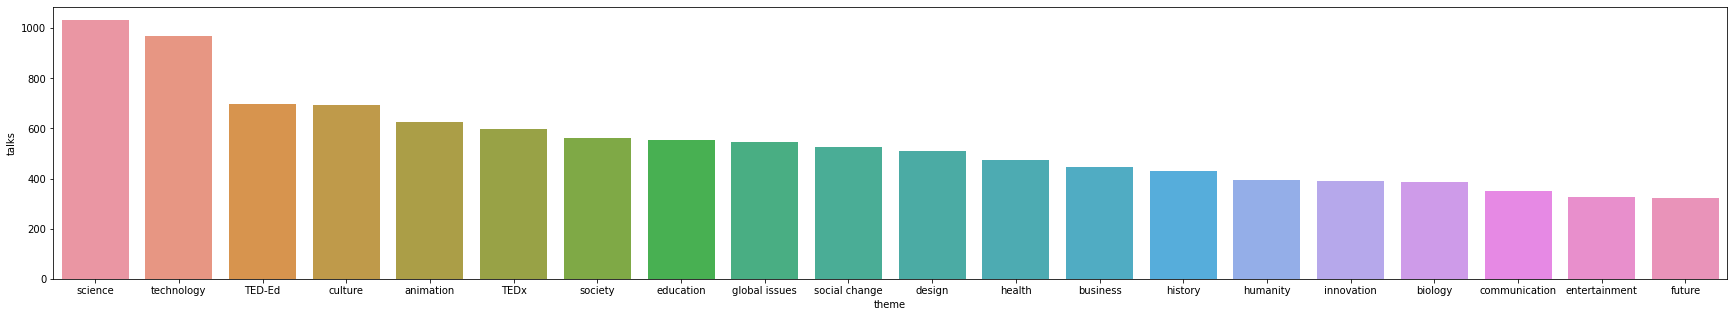

In [30]:
#Verificamos el balance de clases
pop_themes = pd.DataFrame(theme_df['theme'].value_counts()).reset_index()
pop_themes.columns = ['theme', 'talks']

plt.figure(figsize=(30,5))
sns.barplot(x='theme', y='talks', data=pop_themes.head(20))
plt.show()

#### 01.05 - Distancias - Similitud del Coseno


In [31]:
#Preparamos los datos para calcular la Matriz de Frecuencias
Text = theme_df["CleanTranscript"].tolist()

In [32]:
#Generamos Matriz de Frecuencias
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(Text)

In [33]:
#matrix_simil = cosine_similarity(tfidf)
#df_simil = pd.DataFrame(matrix_simil)
#df_simil
#Muriose, no ejecutar

### 02.Modelado

02.00 - Train / Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(theme_df.CleanTranscript, theme_df.theme, test_size=.30)

1838    character disney film one love jiminy cricket ...
3125    restaurants food industry general pretty much ...
1636    witness monumental human progress past decades...
2350    get confession love look people garbage creepy...
3374    organize information graphic designer professi...
Name: CleanTranscript, dtype: object

In [39]:
X_train_transform = vectorizer.fit_transform(X_train.values.astype('U'))
X_test_transform = vectorizer.fit_transform(X_test.values.astype('U'))

02.01 - Stacking

In [41]:
estimators = [
    ('rf', RandomForestClassifier()),
    ('svr', LinearSVC()),
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier()),
    ('ab', AdaBoostClassifier())
]

model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

model.fit(X_train_transform.toarray(), y_train).score(X_test_transform.toarray(), y_test)

model.predict(X_test_transform.toarray())

TypeError: ignored